# English Semantic Textual Similarity

In [8]:
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
def load_sts_dataset(filename):
    """
     Loads a subset of the STS dataset into a DataFrame.
     In particular both sentences and their human rated similarity score.
    :param filename:
    :return:
    """
    sent_pairs = []
    with open(filename, encoding="utf8") as file:
        for line in file:
            ts = line.strip().split("\t")
            sent_pairs.append((ts[5], ts[6], float(ts[4])))
    return pd.DataFrame(sent_pairs, columns=["sentence_1", "sentence_2", "similarity"])

In [11]:
language = "English"
train = load_sts_dataset("sts-train.tsv")
test = load_sts_dataset("sts-test.tsv")

train["id"] = train.index + 1
test["id"] = test.index + 1

Let's see what are the rows in train and test datasets

In [12]:
train[:10]

,sentence_1,sentence_2,similarity,id
0,A plane is taking off.,An air plane is taking off.,5.00,1
1,A man is playing a large flute.,A man is playing a flute.,3.80,2
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80,3
3,Three men are playing chess.,Two men are playing chess.,2.60,4
4,A man is playing the cello.,A man seated is playing the cello.,4.25,5
5,Some men are fighting.,Two men are fighting.,4.25,6
6,A man is smoking.,A man is skating.,0.50,7
7,The man is playing the piano.,The man is playing the guitar.,1.60,8
8,A man is playing on a guitar and singing.,A woman is playing an acoustic guitar and sing...,2.20,9
9,A person is throwing a cat on to the ceiling.,A person throws a cat on the ceiling.,5.00,10


In [13]:
train.describe()

,similarity,id
count,5749.000000,5749.00000
mean,2.700999,2875.00000
std,1.464398,1659.73768
min,0.000000,1.00000
25%,1.500000,1438.00000
50%,3.000000,2875.00000
75%,3.800000,4312.00000
max,5.000000,5749.00000


In [14]:
test[:10]

,sentence_1,sentence_2,similarity,id
0,A girl is styling her hair.,A girl is brushing her hair.,2.500,1
1,A group of men play soccer on the beach.,A group of boys are playing soccer on the beach.,3.600,2
2,One woman is measuring another woman's ankle.,A woman measures another woman's ankle.,5.000,3
3,A man is cutting up a cucumber.,A man is slicing a cucumber.,4.200,4
4,A man is playing a harp.,A man is playing a keyboard.,1.500,5
5,A woman is cutting onions.,A woman is cutting tofu.,1.800,6
6,A man is riding an electric bicycle.,A man is riding a bicycle.,3.500,7
7,A man is playing the drums.,A man is playing the guitar.,2.200,8
8,A man is playing guitar.,A lady is playing the guitar.,2.200,9
9,A man is playing a guitar.,A man is playing a trumpet.,1.714,10


In [15]:
def convert(row):
    if row['similarity'] <= 1.0:
        return '0-1'
    elif 1.0 < row['similarity'] <= 2.0:
        return '1-2'
    elif 2.0 < row['similarity'] <= 3.0:
        return '2-3'
    elif 3.0 < row['similarity'] <= 4.0:
        return '3-4'
    else:
        return '4-5'

train['category'] = train.apply(convert, axis=1)
test['category'] = test.apply(convert, axis=1)

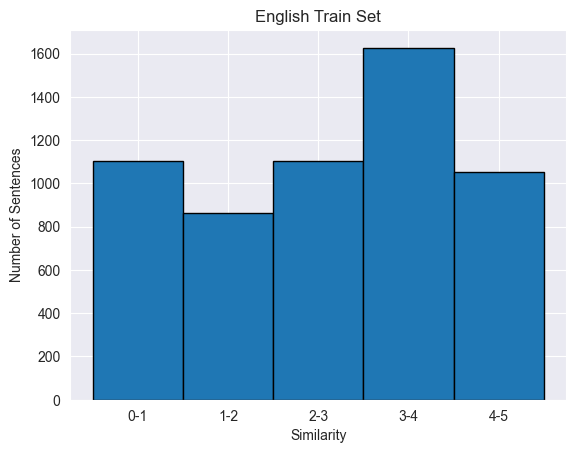

In [16]:
train.groupby("category")['id'].count().plot.bar(width=1,edgecolor = "black",xlabel="Similarity", ylabel="Number of Sentences", rot=0)
plt.title(language + " Train Set")
plt.show()

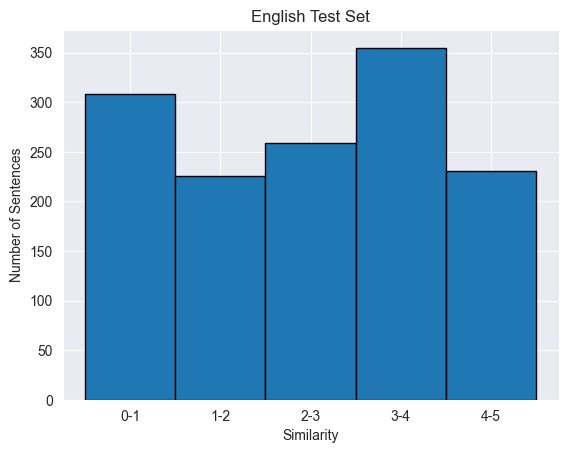

In [17]:
test.groupby("category")['id'].count().plot.bar(width=1,edgecolor = "black",xlabel="Similarity", ylabel="Number of Sentences", rot=0)
plt.title(language + " Test Set")
plt.show()

In [18]:
def normalized_word_Common(row, column_1, column_2):
    w1 = set(map(lambda word: word.lower().strip(), row[column_1].split()))
    w2 = set(map(lambda word: word.lower().strip(), row[column_2].split()))
    return 1.0* len(w1 & w2)

def normalized_word_Total(row, column_1, column_2):
    w1 = set(map(lambda word: word.lower().strip(), row[column_1].split()))
    w2 = set(map(lambda word: word.lower().strip(), row[column_2].split()))
    return 1* (len(w1) + len(w2))

def normalized_word_share(row, column_1, column_2):
    w1 = set(map(lambda word: word.lower().strip(), row[column_1].split()))
    w2 = set(map(lambda word: word.lower().strip(), row[column_2].split()))
    return 1.0*len(w1 & w2) / (len(w1) + len(w2))

def prepare_frequencies(df, id_column, column_1, column_2):
    df['freq_1'] = df.groupby(id_column)[id_column].transform('count')
    df['freq_2'] = df.groupby(id_column)[id_column].transform('count')
    df['s1len'] = df[column_1].str.len()
    df['s2len'] = df[column_2].str.len()
    df['s1_n_words'] = df[column_1].apply(lambda row :len(row.split(" ")))
    df['s2_n_words'] = df[column_2].apply(lambda row :len(row.split(" ")))

    df['word_Common'] = df.apply(normalized_word_Common, args=(column_1,column_2), axis=1)
    df['word_Total'] = df.apply(normalized_word_Total, args=(column_1,column_2), axis = 1)
    df['word_share'] = df.apply(normalized_word_share, args=(column_1,column_2), axis = 1)

    df['freq_s1+s2'] = df['freq_1'] + df['freq_2']
    df['freq_s1-s2'] = abs(df['freq_1'] - df['freq_2'])

    return df


In [19]:
train = prepare_frequencies(train, "id", "sentence_1", "sentence_2")
test = prepare_frequencies(test, "id", "sentence_1", "sentence_2")

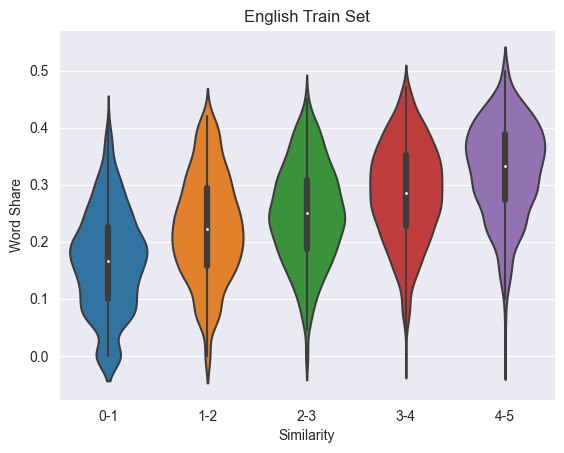

In [20]:
ax = sns.violinplot(x = 'category', y='word_share', data = train[0:], order=[ "0-1", "1-2", "2-3", "3-4", "4-5"])
ax.set_title(language + " Train Set")
ax.set_xlabel('Similarity')
ax.set_ylabel('Word Share')
plt.show()

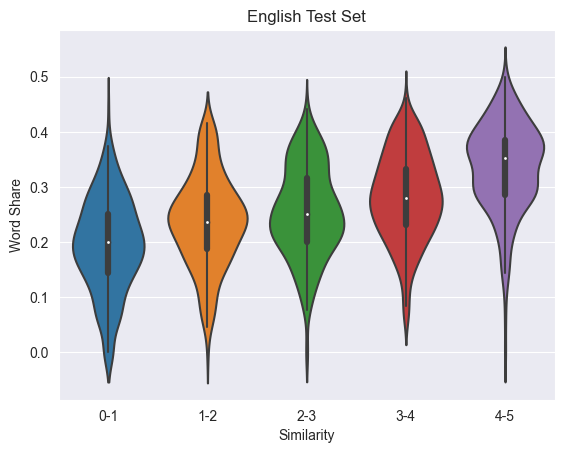

In [21]:
ax = sns.violinplot(x = 'category', y='word_share', data = test[0:], order=[ "0-1", "1-2", "2-3", "3-4", "4-5"])
ax.set_title(language + " Test Set")
ax.set_xlabel('Similarity')
ax.set_ylabel('Word Share')
plt.show()

In [22]:
train[:10]

,sentence_1,sentence_2,similarity,id,category,freq_1,freq_2,s1len,s2len,s1_n_words,s2_n_words,word_Common,word_Total,word_share,freq_s1+s2,freq_s1-s2
0,A plane is taking off.,An air plane is taking off.,5.00,1,4-5,1,1,22,27,5,6,4.0,11,0.363636,2,0
1,A man is playing a large flute.,A man is playing a flute.,3.80,2,3-4,1,1,31,25,7,6,5.0,11,0.454545,2,0
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80,3,3-4,1,1,45,56,9,10,7.0,18,0.388889,2,0
3,Three men are playing chess.,Two men are playing chess.,2.60,4,2-3,1,1,28,26,5,5,4.0,10,0.400000,2,0
4,A man is playing the cello.,A man seated is playing the cello.,4.25,5,4-5,1,1,27,34,6,7,6.0,13,0.461538,2,0
5,Some men are fighting.,Two men are fighting.,4.25,6,4-5,1,1,22,21,4,4,3.0,8,0.375000,2,0
6,A man is smoking.,A man is skating.,0.50,7,0-1,1,1,17,17,4,4,3.0,8,0.375000,2,0
7,The man is playing the piano.,The man is playing the guitar.,1.60,8,1-2,1,1,29,30,6,6,4.0,10,0.400000,2,0
8,A man is playing on a guitar and singing.,A woman is playing an acoustic guitar and sing...,2.20,9,2-3,1,1,41,50,9,9,6.0,17,0.352941,2,0
9,A person is throwing a cat on to the ceiling.,A person throws a cat on the ceiling.,5.00,10,4-5,1,1,45,37,10,8,6.0,16,0.375000,2,0


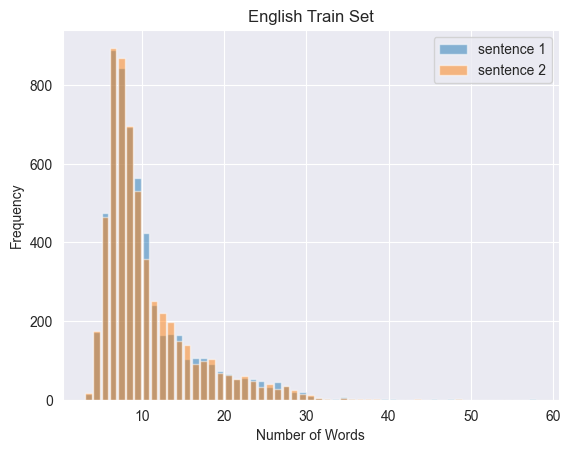

In [23]:
bin_edges = range(min(train['s1_n_words']), max(train['s1_n_words']) + 2, 1)
plt.hist(train['s1_n_words'], bins=bin_edges, rwidth=0.8, alpha=0.5, label="sentence 1")
plt.hist(train['s2_n_words'], bins=bin_edges, rwidth=0.8, alpha=0.5, label="sentence 2")
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title(language + " Train Set")
plt.legend()
plt.show()

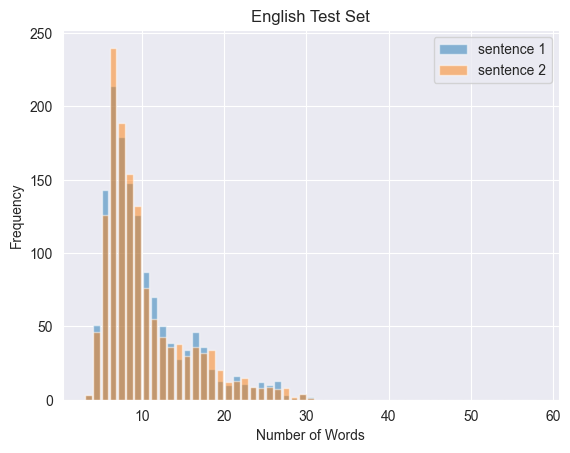

In [24]:
bin_edges = range(min(train['s1_n_words']), max(train['s1_n_words']) + 2, 1)
plt.hist(test['s1_n_words'], bins=bin_edges, rwidth=0.8, alpha=0.5, label="sentence 1")
plt.hist(test['s2_n_words'], bins=bin_edges, rwidth=0.8, alpha=0.5, label="sentence 2")
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title(language + " Test Set")
plt.legend()
plt.show()

In [25]:
train.describe()

,similarity,id,freq_1,freq_2,s1len,s2len,s1_n_words,s2_n_words,word_Common,word_Total,word_share,freq_s1+s2,freq_s1-s2
count,5749.000000,5749.00000,5749.0,5749.0,5749.000000,5749.000000,5749.000000,5749.000000,5749.000000,5749.000000,5749.000000,5749.0,5749.0
mean,2.700999,2875.00000,1.0,1.0,57.761350,57.533136,10.008175,9.943121,4.942251,18.853192,0.254204,2.0,0.0
std,1.464398,1659.73768,0.0,0.0,35.448765,34.646874,5.519161,5.356699,3.597214,9.512729,0.102079,0.0,0.0
min,0.000000,1.00000,1.0,1.0,16.000000,15.000000,3.000000,2.000000,0.000000,5.000000,0.000000,2.0,0.0
25%,1.500000,1438.00000,1.0,1.0,36.000000,35.000000,6.000000,6.000000,3.000000,13.000000,0.181818,2.0,0.0
50%,3.000000,2875.00000,1.0,1.0,47.000000,47.000000,8.000000,8.000000,4.000000,16.000000,0.250000,2.0,0.0
75%,3.800000,4312.00000,1.0,1.0,64.000000,65.000000,11.000000,12.000000,6.000000,21.000000,0.333333,2.0,0.0
max,5.000000,5749.00000,1.0,1.0,368.000000,311.000000,57.000000,48.000000,30.000000,74.000000,0.500000,2.0,0.0


In [26]:
test.describe()

,similarity,id,freq_1,freq_2,s1len,s2len,s1_n_words,s2_n_words,word_Common,word_Total,word_share,freq_s1+s2,freq_s1-s2
count,1379.000000,1379.000000,1379.0,1379.0,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.000000,1379.0,1379.0
mean,2.607917,690.000000,1.0,1.0,53.739666,53.501813,9.826686,9.802756,4.816534,18.452502,0.258824,2.0,0.0
std,1.525517,398.227322,0.0,0.0,32.660162,32.528727,5.140379,5.144103,3.192719,8.969050,0.093908,0.0,0.0
min,0.000000,1.000000,1.0,1.0,16.000000,13.000000,3.000000,2.000000,0.000000,5.000000,0.000000,2.0,0.0
25%,1.315000,345.500000,1.0,1.0,31.000000,32.000000,6.000000,6.000000,3.000000,12.000000,0.200000,2.0,0.0
50%,2.800000,690.000000,1.0,1.0,44.000000,43.000000,8.000000,8.000000,4.000000,16.000000,0.263158,2.0,0.0
75%,3.800000,1034.500000,1.0,1.0,64.000000,62.000000,12.000000,12.000000,6.000000,22.000000,0.333333,2.0,0.0
max,5.000000,1379.000000,1.0,1.0,215.000000,199.000000,30.000000,30.000000,21.000000,52.000000,0.500000,2.0,0.0
